# Binary Classification - Br35H Dataset

## Data Preprocessing and Training Our Model

In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model, normalize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import numpy as np
import pandas as pd
import pickle
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import imageio

In [2]:
IMG_SIZE = 70
DATADIR = os.path.join(os.getcwd(), "Br35H")

In [11]:
X = list()
y = list()

def create_training_data():
    for cn in CLASS_NAMES:
        path = os.path.join(DATADIR, cn)
        for img in os.listdir(path):
            try:
                # Arrays containing all pixel values of 1 image
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # Grayscalling my image
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # Resizing all images to make them uniform
                X.append(np.array(new_array))
                if (cn == "no"):
                    y.append(0)
                else:
                    y.append(1)
            except Exception as e:
                pass

create_training_data()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
# Saving our data into a byte stream so that we don't have to repreocess the data every time

# Serialized X_train
pickle_out_X_train = open("Pickled/X_train.pickle", "wb")
pickle.dump(X_train, pickle_out_X_train)
pickle_out_X_train.close()


# Serialized X_test
pickle_out_X_test = open("Pickled/X_test.pickle", "wb")
pickle.dump(X_test, pickle_out_X_test)
pickle_out_X_test.close()

# Serialized y_train
pickle_out_y_train = open("Pickled/y_train.pickle", "wb")
pickle.dump(y_train, pickle_out_y_train)
pickle_out_y_train.close()

# Serialized y_test
pickle_out_y_test = open("Pickled/y_test.pickle", "wb")
pickle.dump(y_test, pickle_out_y_test)
pickle_out_y_test.close()


In [14]:
# Conerting to arrays to pass into fit() function after creating our model (See below)
X_train = np.array(X_train)
y_train = np.array(y_train)

# Converting all terms in image array to be in range from 0-1
X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

In [16]:
X_test.shape

(900, 70, 70)

In [17]:
# For each time we reach the best the validation accuracy, we will upload a new file (Or checkpoint) during training
model_checkpoint_callback = ModelCheckpoint("BrainTumor.h5", 
                                            save_best_only=True)

early_stop = EarlyStopping(monitor='val_accuracy', mode='max',
                       patience=2,
                       restore_best_weights=True,
                       verbose=1)

In [19]:
model = Sequential()
KERNEL_SIZE = 4
POOL_SIZE = 5
y_train = np.array(y_train)

# First layer (Convolution)
model.add(Conv2D(70, 
          kernel_size=(KERNEL_SIZE, KERNEL_SIZE), # Size of our kernel during Convolution
          input_shape=(IMG_SIZE, IMG_SIZE, 1), # Input shape 70x70, and the 1 represents 1 scheme since these images are grayscale
          padding="same") # 0 padding
         )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(POOL_SIZE,POOL_SIZE)))

# Second layer (Convolution)
model.add(Conv2D(70, kernel_size=(KERNEL_SIZE, KERNEL_SIZE), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(POOL_SIZE, POOL_SIZE)))

# Third Layer (Flatten) - Flatten the 2D image to make it fit into our 1D dense layer
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))

# Fourth Layer - Output layer
model.add(Dense(1))
model.add(Activation("sigmoid"))



model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Out of our entire training data, part of it (Which is 10% in this case) is our validation
model.fit(X_train, y_train, batch_size=64, validation_split=0.1, epochs=15,  callbacks=[model_checkpoint_callback, early_stop])

Epoch 1/15
30/30 [==============================] - 10s 277ms/step - loss: 0.6488 - accuracy: 0.6175 - val_loss: 0.5877 - val_accuracy: 0.7190
Epoch 2/15
30/30 [==============================] - 8s 284ms/step - loss: 0.5180 - accuracy: 0.7587 - val_loss: 0.5232 - val_accuracy: 0.7524
Epoch 3/15
30/30 [==============================] - 8s 273ms/step - loss: 0.4520 - accuracy: 0.7963 - val_loss: 0.4850 - val_accuracy: 0.7905
Epoch 4/15
30/30 [==============================] - 8s 276ms/step - loss: 0.4161 - accuracy: 0.8201 - val_loss: 0.4884 - val_accuracy: 0.8000
Epoch 5/15
30/30 [==============================] - 9s 306ms/step - loss: 0.3608 - accuracy: 0.8550 - val_loss: 0.3971 - val_accuracy: 0.8286
Epoch 6/15
30/30 [==============================] - 9s 314ms/step - loss: 0.3061 - accuracy: 0.8788 - val_loss: 0.3655 - val_accuracy: 0.8571
Epoch 7/15
30/30 [==============================] - 9s 300ms/step - loss: 0.2473 - accuracy: 0.9116 - val_loss: 0.3151 - val_accuracy: 0.9000
Epoch

In [92]:
plot_model(model, show_shapes=True, expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 70, 70, 70)        1190      
                                                                 
 activation_4 (Activation)   (None, 70, 70, 70)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 70)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 70)        78470     
                                                                 
 activation_5 (Activation)   (None, 14, 14, 70)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 70)         0         
 2D)                                                  

Text(0, 0.5, 'Percentage')

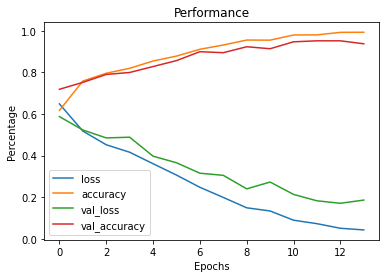

In [22]:
losses = pd.DataFrame(model.history.history)

losses.plot()
plt.title("Performance")
plt.xlabel("Epochs")
plt.ylabel("Percentage")

## Testing Our Model

In [96]:
X_test = pickle.load(open(os.path.join(os.getcwd(), "Pickled/X_test.pickle"), "rb"))
y_test = pickle.load(open(os.path.join(os.getcwd(), "Pickled/y_test.pickle"), "rb"))
y_train = pickle.load(open(os.path.join(os.getcwd(), "Pickled/y_train.pickle"), "rb"))

In [37]:
# Loading our model and training it
model = load_model("BrainTumor.h5")

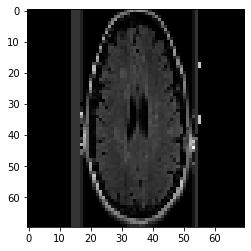

In [39]:
count = 0
for t in X_test:
    plt.imshow(t, cmap="gray")
    if (count == 28):
        break
    count += 1

In [40]:
predictions = (model.predict(X_test) > 0.5)*1

29/29 [==============================] - 1s 34ms/step


In [50]:
pickle_out_predictions = open("Pickled/predictions.pickle", "wb")
pickle.dump(predictions, pickle_out_predictions)
pickle_out_predictions.close()

In [42]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       461
           1       0.97      0.95      0.96       439

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



 - **Accuracy** = Total Correct Outcomes / Total Outcomes
 - **Precision** = True Positives / (True Positives + False Positives)
 - **Recall** = True Positives / (True Positives + False Negatives)

In [45]:
print(confusion_matrix(y_test, predictions))

[[448  13]
 [ 23 416]]


Test accuracy of this model: 0.96


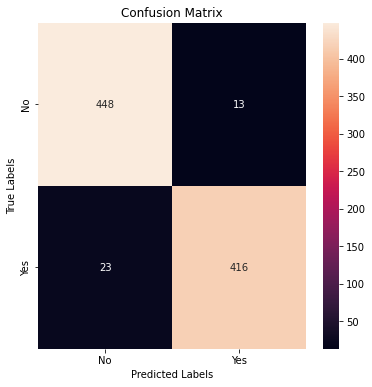

In [89]:
plt.figure(figsize = (6,6))
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')

s = sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')
s.set(xlabel='Predicted Labels', ylabel='True Labels',  xticklabels=["No", "Yes"],  yticklabels=["No", "Yes"])

print(f"Test accuracy of this model: {accuracy_score(y_test, predictions)}")

This **confusion matrix** represents the 900 images we used as our test data.

# Making Predictions from 'Brain Image Clean' Dataset

**To further experiment with this model, I've decided to use another dataset of more brain MRI images to detect whether they have tumors.**

Samples of images that have no tumor vs images that have tumors

In [160]:
# Helper function used throughout this section
def pre_process(img):
    IMG_SIZE = 70
    img_array = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

1/1 [==============================] - 0s 23ms/step
no


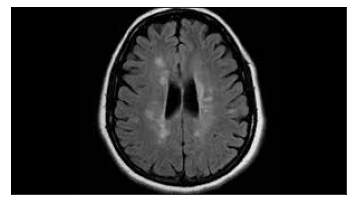

In [157]:
image = r"Brain Image Clean\no\13 no.jpg"
prediction = model.predict([pre_process(image)]) # REMEMBER: Predict takes in a list
plt.xticks([])
plt.yticks([])

plt.imshow(imageio.imread(image))
print(CLASS_NAMES[int(prediction[0][0])])

1/1 [==============================] - 0s 22ms/step
yes


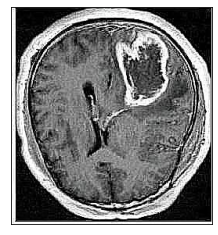

In [158]:
image = r"Brain Image Clean\yes\y988.jpg"
prediction = model.predict([pre_process(image)]) # REMEMBER: Predict takes in a list
plt.xticks([])
plt.yticks([])

plt.imshow(imageio.imread(image))
print(CLASS_NAMES[int(prediction[0][0])])

In [152]:
pd.set_option('display.max_colwidth', None)

In [170]:
# Retrieving all filepaths from Brain Image Clean and loading into a dataframe called df
filepaths = list()
CLASS_NAMES = ["no", "yes"]

BRAIN_IMG_CLEAN

for cn in CLASS_NAMES:
    path = os.path.join("Brain Image Clean", cn)
    for img in os.listdir(path):
        filepaths.append(os.path.join(path, img))

file_dict = {"filepath": filepaths}
df = pd.DataFrame(file_dict)

In [161]:
# Loading 2 more columns into our DataFrame: Predicted from machine and actual
actual_col = list()
predicted_col = list()

for index, row in df.iterrows():
    # Predicting each image in the test folder and putting that into our dataframe
    p = model.predict([pre_process(row["filepath"])])
    predicted_col.append(CLASS_NAMES[int(p[0][0])]) # Predictions made by machine
    actual_col.append(row["filepath"].split('\\')[-2]) # Actual results

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


In [171]:
df

,filepath
0,Brain Image Clean\no\1 no.jpeg
1,Brain Image Clean\no\10 no.jpg
2,Brain Image Clean\no\11 no.jpg
3,Brain Image Clean\no\12 no.jpg
4,Brain Image Clean\no\13 no.jpg
...,...
909,Brain Image Clean\yes\y987.jpg
910,Brain Image Clean\yes\y988.jpg
911,Brain Image Clean\yes\y99.jpg
912,Brain Image Clean\yes\y997.jpg


In [172]:
pred_vs_actual = {"Predicted": predicted_col, "Actual": actual_col}
addon = pd.DataFrame(pred_vs_actual)

results = pd.concat([df, addon], axis=1)
results.to_csv("brain_image_clean_predictions.csv", index=False) # Saving all of my predictions data to a csv

In [173]:
# Reading saved CSV into a variable
BIC_pred = pd.read_csv("brain_image_clean_predictions.csv")

In [176]:
pd.set_option('display.max_rows', None)
BIC_pred
#pd.reset_option('display.max_rows')

,filepath,Predicted,Actual
0,Brain Image Clean\no\1 no.jpeg,no,no
1,Brain Image Clean\no\10 no.jpg,no,no
2,Brain Image Clean\no\11 no.jpg,no,no
3,Brain Image Clean\no\12 no.jpg,no,no
4,Brain Image Clean\no\13 no.jpg,no,no
5,Brain Image Clean\no\14 no.jpg,no,no
6,Brain Image Clean\no\2 no.jpeg,no,no
7,Brain Image Clean\no\3 no.jpg,no,no
8,Brain Image Clean\no\4 no.jpg,no,no
9,Brain Image Clean\no\5 no.jpg,no,no
